In [1]:
import copy
import os
import random
import time
from pprint import pprint

import albumentations as A
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from albumentations.pytorch import ToTensorV2
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.metrics import (classification_report, confusion_matrix,
                             multilabel_confusion_matrix)
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms

#set up things deterministic
# random state 7 produces 
#  test Loss: 0.8380 Acc: 0.9038 with weighted cross entropy loss
#  test Loss: 0.2485 Acc: 0.9231 with focal loss

random_state = 7  # affects the splitting of dataset too.
torch.manual_seed(random_state)
random.seed(random_state)
np.random.seed(random_state)
torch.backends.cudnn.deterministic = True


In [2]:
df = pd.read_csv("gicsd_labels.csv", skipinitialspace=True)
df.LABEL = df.LABEL.str.strip()
df["IMG_PATH"] = os.path.join(os.getcwd(), "images/") + df.IMAGE_FILENAME 
print(df.head())
full_vis = df[df["LABEL"] == "FULL_VISIBILITY"]
part_vis = df[df["LABEL"] == "PARTIAL_VISIBILITY"]
no_vis = df[df["LABEL"] == "NO_VISIBILITY"]
print(len(full_vis), len(part_vis), len(no_vis))
assert  len(full_vis)+ len(part_vis)+ len(no_vis) == 800

     IMAGE_FILENAME               LABEL  \
0   GICSD_1_0_3.png     FULL_VISIBILITY   
1  GICSD_1_0_13.png     FULL_VISIBILITY   
2  GICSD_1_1_33.png  PARTIAL_VISIBILITY   
3  GICSD_1_1_53.png     FULL_VISIBILITY   
4  GICSD_1_2_73.png     FULL_VISIBILITY   

                                        IMG_PATH  
0   /home/sid/git/ml_task/images/GICSD_1_0_3.png  
1  /home/sid/git/ml_task/images/GICSD_1_0_13.png  
2  /home/sid/git/ml_task/images/GICSD_1_1_33.png  
3  /home/sid/git/ml_task/images/GICSD_1_1_53.png  
4  /home/sid/git/ml_task/images/GICSD_1_2_73.png  
646 123 31


In [3]:
full_vis_dict = {}
for row in full_vis.iterrows(): 
  path = row[1]["IMG_PATH"]
  name = row[1]["IMAGE_FILENAME"] 
  bgr = cv2.imread(path)
  rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
  gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
  full_vis_dict[name] = (rgb, bgr, gray)
  #print(np.min(gray), np.max(gray))

part_vis_dict = {}
for row in part_vis.iterrows():
  path = row[1]["IMG_PATH"]
  name = row[1]["IMAGE_FILENAME"]
  bgr = cv2.imread(path)
  rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
  gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
  part_vis_dict[name] = (rgb, bgr, gray)
  #print(np.min(gray), np.max(gray))

no_vis_dict = {}
for row in no_vis.iterrows():
  path = row[1]["IMG_PATH"]
  name = row[1]["IMAGE_FILENAME"]
  bgr = cv2.imread(path)
  rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
  gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
  no_vis_dict[name] = (rgb, bgr, gray)
  #print(np.min(gray), np.max(gray))

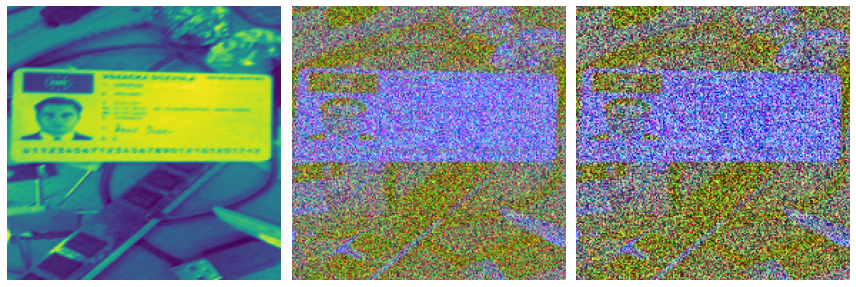

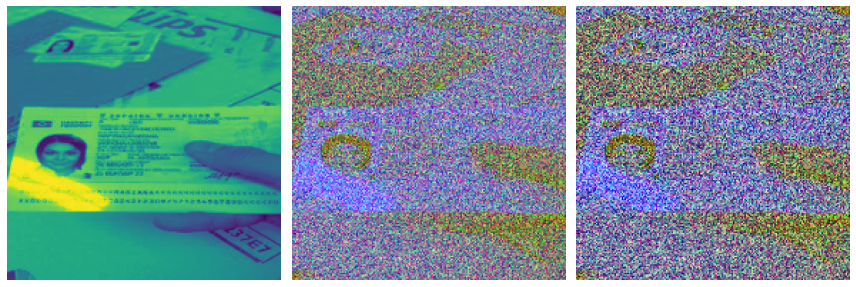

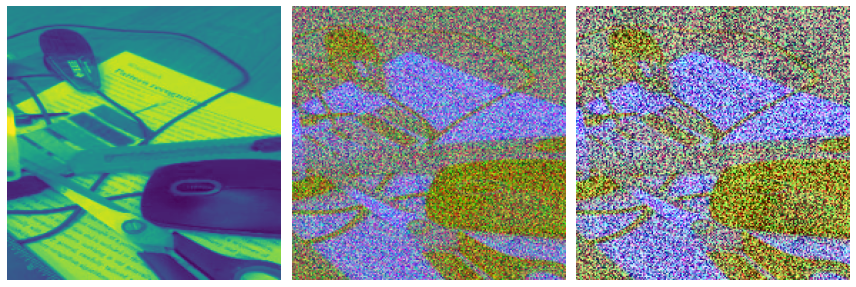

In [4]:
def apply_clahe(rgb):
    image = Image.fromarray(rgb).convert('RGB')
    aug = A.Compose({
            A.CLAHE(3,(8,8)),
            })
    
    image = aug(image=np.array(image))['image']
    return image

def  visualize(imgs, figsize=(12,6)):
    figure, ax = plt.subplots(nrows=1, ncols=len(imgs), figsize=figsize)
    for i in range(len(imgs)):
        image = imgs[i]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
    
key = random.choice(list(full_vis_dict))
rgb, bgr, gray = full_vis_dict[key]
visualize([bgr[:,:,0],rgb, apply_clahe(rgb)])

key = random.choice(list(part_vis_dict))
rgb, bgr, gray = part_vis_dict[key]
visualize([bgr[:,:,0],rgb, apply_clahe(rgb)])

key = random.choice(list(no_vis_dict))
rgb, bgr, gray = no_vis_dict[key]
visualize([bgr[:,:,0],rgb, apply_clahe(rgb)])

In [5]:
df_copy = df.copy()

Y = df_copy.pop("LABEL").to_frame()
X = df_copy

# stratified splitting the data to 74% train, 13% val and 13% test for maintaing class imbalance
x_train, x_test, y_train, y_test  = train_test_split(X, Y, random_state=random_state, stratify=Y, test_size=0.26)
x_test, x_val, y_test, y_val  = train_test_split(x_test, y_test, random_state=random_state, stratify=y_test, test_size=0.5)

print(len(x_train), len(y_train) ,len(x_test), len(y_test), len(x_val), len(y_val))

print((y_train.LABEL.value_counts()/y_train.LABEL.count())*100)
print((y_test.LABEL.value_counts()/y_test.LABEL.count())*100)
print((y_val.LABEL.value_counts()/y_val.LABEL.count())*100)


592 592 104 104 104 104
FULL_VISIBILITY       80.743243
PARTIAL_VISIBILITY    15.371622
NO_VISIBILITY          3.885135
Name: LABEL, dtype: float64
FULL_VISIBILITY       80.769231
PARTIAL_VISIBILITY    15.384615
NO_VISIBILITY          3.846154
Name: LABEL, dtype: float64
FULL_VISIBILITY       80.769231
PARTIAL_VISIBILITY    15.384615
NO_VISIBILITY          3.846154
Name: LABEL, dtype: float64


In [6]:
print(y_train.LABEL.value_counts())
weights = [646/646, 646/123, 646/31]  #based on overall distribution
weights

FULL_VISIBILITY       478
PARTIAL_VISIBILITY     91
NO_VISIBILITY          23
Name: LABEL, dtype: int64


[1.0, 5.252032520325203, 20.838709677419356]

In [7]:
class CustomImageDataset(Dataset):
    
    def __init__(self, x_df, y_df, transform, album=False):
        self.x = x_df.IMG_PATH.to_list()
        self.y = y_df.LABEL.to_list()
        self.transform = transform
        self.class_map = {"FULL_VISIBILITY" : 0,
                          "PARTIAL_VISIBILITY": 1,
                          "NO_VISIBILITY": 2,
                          }
        self.album = album
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        img = Image.open(self.x[idx]).convert("RGB")        
        if self.transform is not None:
            if self.album:
                img = cv2.imread(self.x[idx])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = self.transform(image=img)["image"]
            else:
                img = self.transform(img)
                
            
        class_name = self.y[idx] 
        class_id = self.class_map[class_name]
        class_id = torch.tensor([class_id])
        
        return img, class_id
    
# use transformation to first resize image to 224x224 from 192x192 as the model needs that
# apply normalization based on the dataset on which the model was initially trained on. (pretrained weights)
# convert ToTensor for pytorch
# these steps should be same in all splits
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# for augmentations in addition we can do random flips, CLAHE equalization, ColorJitter
# channelshuffle seemed to improve
album_transforms = {
    'train': A.Compose([
        A.Resize(224, 224),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.CLAHE(4.0,(8,8)),
        A.ColorJitter(),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]),
    'val': A.Compose([
        A.Resize(224, 224), 
        A.CLAHE(4.0,(8,8)),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(), 
    ]),
    'test': A.Compose([
        A.Resize(224, 224), 
        A.CLAHE(4.0,(8,8)),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(), 
    ])
}

x_df = {'train': x_train, 'val': x_val, 'test': x_test}
y_df = {'train': y_train, 'val': y_val, 'test': y_test}

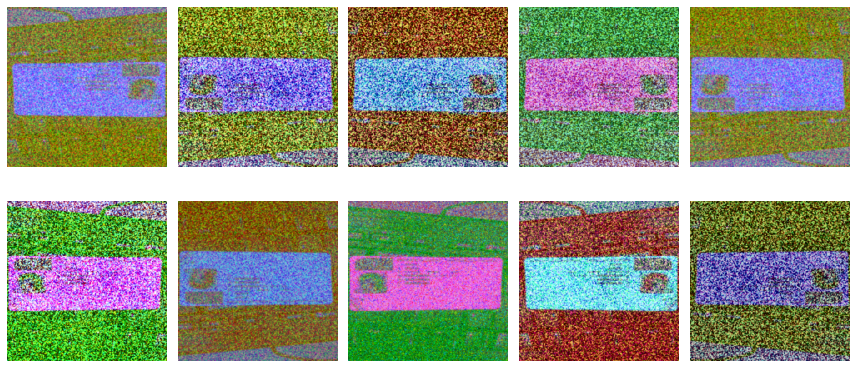

In [8]:
use_albumentations = True

if use_albumentations:
    dataloaders = { split : DataLoader(
                                CustomImageDataset(x_df[split], y_df[split], album_transforms[split],album=use_albumentations), 
                                batch_size = 64,
                                num_workers = 4)
                    for split in ['train', 'val', 'test']}
    
    def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
        dataset = copy.deepcopy(dataset)
        dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
        rows = samples // cols
        figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
        for i in range(samples):
            image, _ = dataset[idx]
            ax.ravel()[i].imshow(image)
            ax.ravel()[i].set_axis_off()
        plt.tight_layout()
        plt.show()
    
    visualize_augmentations(CustomImageDataset(x_df["train"], y_df["train"], album_transforms["train"], album=use_albumentations))
else:
    dataloaders = { split : DataLoader(
                            CustomImageDataset(x_df[split], y_df[split], data_transforms[split],album=use_albumentations), 
                            batch_size = 64,
                            num_workers = 4)
                for split in ['train', 'val', 'test']}



In [9]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = None
    
    training_reports = []
    validation_reports = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_preds = []
            running_labels = []
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels = labels.reshape(inputs.shape[0])
                #print(labels, labels.shape)
                #print(inputs.shape)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate losss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    #if phase == "val":
                    #    print(preds)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_preds.extend(list(preds.cpu().detach().numpy()))
                running_labels.extend(list(labels.data.cpu().detach().numpy())) 
                
            report_dict = classification_report(running_labels, 
                                                 running_preds,
                                                 labels=[0,1,2],
                                                 target_names=["FULL_VISIBILITY","PARTIAL_VISIBILITY","NO_VISIBILITY"], 
                                                 output_dict=True,
                                                 zero_division=0)
            report_dict["MATRIX"] = confusion_matrix(running_labels, running_preds)
            
            if phase == 'train':
                scheduler.step()
                training_reports.append(report_dict)
            else:
                validation_reports.append(report_dict)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, training_reports, validation_reports, best_epoch

In [10]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
print(num_ftrs)

# we have 3 output classes
model_ft.fc = nn.Linear(num_ftrs, 3)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss(weight=torch.Tensor(weights).to(device))

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of gamma every 10 epochs 
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.5)

#print(model_ft)

512


In [11]:
# Taken from here https://github.com/mbsariyildiz/focal-loss.pytorch/blob/master/focalloss.py
# switching to this focal loss increased accuracy by 2 percentage points and also converged training sooner


class FocalLoss(nn.Module):

    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha, (float, int)): self.alpha = torch.Tensor([alpha, 1 - alpha])
        if isinstance(alpha, list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0), input.size(1), -1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1, 2)                         # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1, input.size(2))    # N,H*W,C => N*H*W,C
        target = target.view(-1, 1)

        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = logpt.exp()

        if self.alpha is not None:
            if self.alpha.type() != input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0, target.data.view(-1))
            logpt = logpt * at

        loss = -1 * (1 - pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()
    
criterion = FocalLoss()


In [12]:
num_epochs=150
model_ft, hist, tr_report, val_report, best_epoch = train_model(model_ft, 
                                                                dataloaders, 
                                                                criterion, 
                                                                optimizer_ft, 
                                                                exp_lr_scheduler, 
                                                                num_epochs=num_epochs)

Epoch 0/149
----------
train Loss: 1.0908 Acc: 0.6976
val Loss: 0.6487 Acc: 0.8173

Epoch 1/149
----------
train Loss: 0.6263 Acc: 0.7736
val Loss: 0.6695 Acc: 0.8077

Epoch 2/149
----------
train Loss: 0.5255 Acc: 0.8024
val Loss: 0.5219 Acc: 0.8077

Epoch 3/149
----------
train Loss: 0.4474 Acc: 0.8142
val Loss: 0.8977 Acc: 0.8077

Epoch 4/149
----------
train Loss: 0.3946 Acc: 0.8463
val Loss: 0.4407 Acc: 0.8269

Epoch 5/149
----------
train Loss: 0.3734 Acc: 0.8530
val Loss: 0.4648 Acc: 0.8173

Epoch 6/149
----------
train Loss: 0.3337 Acc: 0.8564
val Loss: 0.4221 Acc: 0.8365

Epoch 7/149
----------
train Loss: 0.2943 Acc: 0.8649
val Loss: 0.4330 Acc: 0.8269

Epoch 8/149
----------
train Loss: 0.2867 Acc: 0.8834
val Loss: 0.3040 Acc: 0.8654

Epoch 9/149
----------
train Loss: 0.2394 Acc: 0.9088
val Loss: 0.4285 Acc: 0.8462

Epoch 10/149
----------
train Loss: 0.2304 Acc: 0.9122
val Loss: 0.3158 Acc: 0.9231

Epoch 11/149
----------
train Loss: 0.2370 Acc: 0.9037
val Loss: 0.4428 Acc

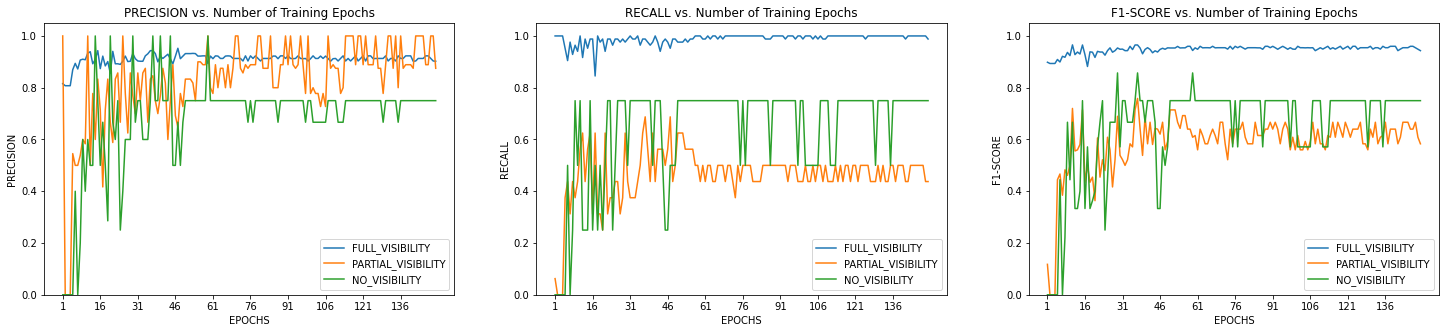

In [13]:
val_accuracy = [x["accuracy"] for x in val_report]
fv_precision = [x["FULL_VISIBILITY"]["precision"] for x in val_report]
fv_recall = [x["FULL_VISIBILITY"]["recall"] for x in val_report]
fv_f1 = [x["FULL_VISIBILITY"]["f1-score"] for x in val_report]
pv_precision = [x["PARTIAL_VISIBILITY"]["precision"] for x in val_report]
pv_recall = [x["PARTIAL_VISIBILITY"]["recall"] for x in val_report]
pv_f1 = [x["PARTIAL_VISIBILITY"]["f1-score"] for x in val_report]
nv_precision = [x["NO_VISIBILITY"]["precision"] for x in val_report]
nv_recall = [x["NO_VISIBILITY"]["recall"] for x in val_report]
nv_f1 = [x["NO_VISIBILITY"]["f1-score"] for x in val_report]

plt.figure(figsize=(25,5))
plt.subplot(1, 3, 1)
plt.title("PRECISION vs. Number of Training Epochs")
plt.xlabel("EPOCHS")
plt.ylabel("PRECISION")
plt.plot(range(1,num_epochs+1), fv_precision, label="FULL_VISIBILITY")
plt.plot(range(1,num_epochs+1), pv_precision, label="PARTIAL_VISIBILITY")
plt.plot(range(1,num_epochs+1), nv_precision, label="NO_VISIBILITY")
plt.ylim((0,1.05))
plt.xticks(np.arange(1, num_epochs+1, 15))
plt.legend() 

plt.subplot(1, 3, 2)
plt.title("RECALL vs. Number of Training Epochs")
plt.xlabel("EPOCHS")
plt.ylabel("RECALL")
plt.plot(range(1,num_epochs+1), fv_recall, label="FULL_VISIBILITY")
plt.plot(range(1,num_epochs+1), pv_recall, label="PARTIAL_VISIBILITY")
plt.plot(range(1,num_epochs+1), nv_recall, label="NO_VISIBILITY")
plt.ylim((0,1.05))
plt.xticks(np.arange(1, num_epochs+1, 15))
plt.legend() 

plt.subplot(1, 3, 3)
plt.title("F1-SCORE vs. Number of Training Epochs")
plt.xlabel("EPOCHS")
plt.ylabel("F1-SCORE")
plt.plot(range(1,num_epochs+1), fv_f1, label="FULL_VISIBILITY")
plt.plot(range(1,num_epochs+1), pv_f1, label="PARTIAL_VISIBILITY")
plt.plot(range(1,num_epochs+1), nv_f1, label="NO_VISIBILITY")
plt.ylim((0,1.05))
plt.xticks(np.arange(1, num_epochs+1, 15))
plt.legend()
plt.show()


In [14]:
model_ft.eval()   # Set model to evaluate mode

running_loss = 0.0
running_corrects = 0
running_preds = []
running_labels = []

for inputs, labels in dataloaders["test"]:
    inputs = inputs.to(device)
    labels = labels.to(device)
    labels = labels.reshape(inputs.shape[0])
    #print(labels, labels.shape)
    #print(inputs.shape)
    # zero the parameter gradients
    optimizer_ft.zero_grad()

    # forward
    # track history if only in train
    with torch.set_grad_enabled(False):
        # Get model outputs and calculate loss
        outputs = model_ft(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)

    # statistics
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    running_preds.extend(list(preds.cpu().detach().numpy()))
    running_labels.extend(list(labels.data.cpu().detach().numpy())) 
    
test_report_dict = classification_report(running_labels, 
                                         running_preds, 
                                         labels=[0,1,2],
                                         target_names=["FULL_VISIBILITY","PARTIAL_VISIBILITY","NO_VISIBILITY"], 
                                         output_dict=True,
                                         zero_division=0)
test_report_dict["MATRIX"] = confusion_matrix(running_labels, running_preds)
            
    
pprint(test_report_dict)
    
test_loss = running_loss / len(dataloaders["test"].dataset)
test_acc = running_corrects.double() / len(dataloaders["test"].dataset)

print('{} Loss: {:.4f} Acc: {:.4f}'.format("test", test_loss, test_acc))


{'FULL_VISIBILITY': {'f1-score': 0.9707602339181286,
                     'precision': 0.9540229885057471,
                     'recall': 0.9880952380952381,
                     'support': 84},
 'MATRIX': array([[83,  1,  0],
       [ 4, 10,  2],
       [ 0,  1,  3]]),
 'NO_VISIBILITY': {'f1-score': 0.6666666666666665,
                   'precision': 0.6,
                   'recall': 0.75,
                   'support': 4},
 'PARTIAL_VISIBILITY': {'f1-score': 0.7142857142857143,
                        'precision': 0.8333333333333334,
                        'recall': 0.625,
                        'support': 16},
 'accuracy': 0.9230769230769231,
 'macro avg': {'f1-score': 0.7839042049568364,
               'precision': 0.7957854406130268,
               'recall': 0.7876984126984127,
               'support': 104},
 'weighted avg': {'f1-score': 0.9196067090803933,
                  'precision': 0.92183908045977,
                  'recall': 0.9230769230769231,
                  'support

array([[98.80952381,  1.19047619,  0.        ],
       [25.        , 62.5       , 12.5       ],
       [ 0.        , 25.        , 75.        ]])


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

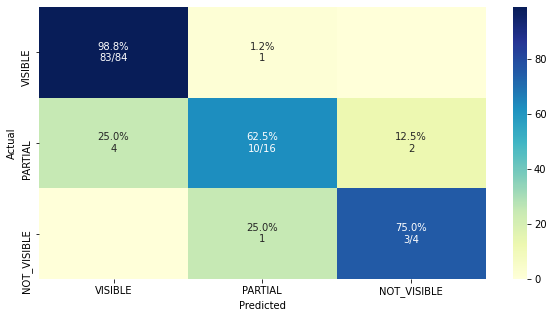

In [15]:
# PLOT CONFUSION MATRIX FOR THE TEST SET NEVER SEEN BY MODEL BEFORE

cm = test_report_dict["MATRIX"]
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
#pprint(cm_perc)
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)
cm = pd.DataFrame(cm_perc, 
                  index=["VISIBLE","PARTIAL","NOT_VISIBLE"], 
                  columns=["VISIBLE","PARTIAL","NOT_VISIBLE"])
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

# FINAL TEST SET RESULTS 
## (for this notebook with the set seed)



**Overall accuracy**  =   92.31%

**VISIBLE CLASS precision**  =  98.8%  or 83/84

**PARTIALLY VISIBLE CLASS precision** = 62.5% or 10/16

**NOT VISIBLE CLASS precision** = 75.0% or 3/4